<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Computation with Xarray

In this lesson, we discuss how to do scientific computations with xarray
objects. Our learning goals are as follows. By the end of the lesson, we will be
able to:

- Apply basic arithmetic and numpy functions to xarray DataArrays / Dataset.
- Use Xarray's label-aware reduction operations (e.g. `mean`, `sum`) weighted
  reductions.
- Apply arbitrary functions to Xarray data via `apply_ufunc`.
- Use Xarray's broadcasting to compute on arrays of different dimensionality.
- Perform "split / apply / combine" workflows in Xarray using `groupby`,
  including
  - reductions within groups
  - transformations on groups
- Use the `resample`, `rolling` and `coarsen` functions to manipulate data.


In [31]:
import expectexception
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

## Example Dataset

First we load a dataset. We will use the
[NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5)
product, a widely used and trusted gridded compilation of of historical data
going back to 1854.

Since the data is provided via an
[OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly
without downloading anything:


In [32]:
### NOTE: If hundreds of people connect to this server at once and download the same dataset,
###       things might not go so well! Recommended to use the Google Cloud copy instead.

# url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
# # drop an unnecessary variable which complicates some operations
# ds = xr.open_dataset(url, drop_variables=["time_bnds"])
# # will take a minute or two to complete
# ds = ds.sel(time=slice("1960", "2018")).load()
# ds

In [33]:
import gcsfs

fs = gcsfs.GCSFileSystem(token="anon")
ds = xr.open_zarr(
    fs.get_mapper("gs://pangeo-noaa-ncei/noaa.ersst.v5.zarr"), consolidated=True
).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    Conventions:                     CF-1.6, ACDD-1.3
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    cdm_data_type:                   Grid
    citation:                        Huang et al, 2017: Extended Reconstructe...
    climatology:                     Climatology is based on 1971-2000 SST, X...
    ...                              ...
    project:                         NOAA Extended Reconstructed Sea Surface ...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    source_comment:                  SSTs were observed by conventional therm...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    summary:                         ERSST.v5 is developed based on v4 after ...
    title:                           NOAA ERSSTv5 (in situ only)

Let's do some basic visualizations of the data, just to make sure it looks
reasonable.


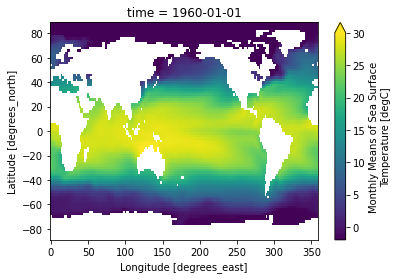

In [34]:
ds.sst[0].plot(vmin=-2, vmax=30)

## Basic Arithmetic

Xarray dataarrays and datasets work seamlessly with arithmetic operators and
numpy array functions.

For example, imagine we want to convert the temperature (given in Celsius) to
Kelvin:


In [35]:
sst_kelvin = ds.sst + 273.15
sst_kelvin

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
array([[[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
...
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

The dimensions and coordinates were preseved following the operation.

<div class="alert alert-warning">
    <strong>Warning:</strong> Although many xarray datasets have a <code>units</code> attribute, which is used in plotting,
    Xarray does not inherently understand units. However, work is underway to integrate xarray
    with <a href="https://pint.readthedocs.io/en/0.12/">pint</a>, which will provide full unit-aware operations.
</div>

We can apply more complex functions, including numpy ufuncs, to Xarray objects.
Imagine we wanted to compute the following expression as a function of SST
($\Theta$) in Kelvin:

$$ f(\Theta) =  0.5 \ln(\Theta^2) $$


In [36]:
f = 0.5 * np.log(sst_kelvin ** 2)
f

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
array([[[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
...
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        [5.60341, 5.60341, 5.60341, ..., 5.60341, 5.60341, 5.60341],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

## Applying Aribtrary Functions

It's awesome that we can call `np.log(ds)` and have it "just work". However, not
all third party libraries work this way.

In this example, we will use functions from the
[Gibbs Seawater Toolkit](https://teos-10.github.io/GSW-Python/), a package for
the thermodynamics of seawater. This package provides ufuncs that operate on
numpy arrays.


In [37]:
import gsw

# an example function
# http://www.teos-10.org/pubs/gsw/html/gsw_t90_from_t68.html
gsw.t90_from_t68?

Signature: gsw.t90_from_t68(t68)
Docstring:
ITS-90 temperature from IPTS-68 temperature

This conversion should be applied to all in-situ
data collected between 1/1/1968 and 31/12/1989.
File:      ~/anaconda3/envs/xarray/lib/python3.8/site-packages/gsw/conversions.py
Type:      function


In [38]:
gsw.t90_from_t68(ds.sst)  # -> returns a numpy array

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
array([[[-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        [-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        [-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        [-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        [-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        [-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        [-1.799568, -1.799568, -1.799568, ..., -1.799568, -1.799568,
         -1.799568],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

It would be nice to keep our dimensions and coordinates. We can accomplish this
with `xr.apply_ufunc`.


In [39]:
xr.apply_ufunc(gsw.t90_from_t68, ds.sst)

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)>
array([[[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        [-1.79956806, -1.79956806, -1.79956806, ..., -1.79956806,
         -1.79956806, -1.79956806],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

<div class="alert alert-info">
    <strong>Note:</strong> <code>apply_ufunc</code> is a powerful and mysterious function.
    It has many options for doing more complicated things.
    Unfortunately, we don't have time to go into more depth here.
    Please consult the [Xarray docs](http://xarray.pydata.org/en/latest/generated/xarray.apply_ufunc.html) for more details.
</div>


## Reductions

Just like in numpy, we can reduce xarray DataArrays along any number of axes:


In [40]:
sst = ds.sst
sst.mean(axis=0)

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[-1.7993844, -1.7993953, -1.7994034, ..., -1.799569 , -1.799457 ,
        -1.799379 ],
       [-1.7994268, -1.7993473, -1.799294 , ..., -1.7998592, -1.7996504,
        -1.7995317],
       [-1.7999867, -1.7998204, -1.7997179, ..., -1.799865 , -1.7999135,
        -1.7999635],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [41]:
sst.mean(axis=(1, 2))

<xarray.DataArray 'sst' (time: 708)>
array([13.447333 , 13.538178 , 13.560617 , 13.449021 , 13.469315 ,
       13.454981 , 13.72113  , 13.916064 , 13.822409 , 13.53989  ,
       13.323178 , 13.364261 , 13.491084 , 13.624221 , 13.623529 ,
       13.525916 , 13.48518  , 13.5291395, 13.710998 , 13.902636 ,
       13.786833 , 13.500918 , 13.322204 , 13.324784 , 13.4614725,
       13.554375 , 13.570085 , 13.467039 , 13.464627 , 13.515269 ,
       13.7487135, 13.86036  , 13.797006 , 13.499739 , 13.294295 ,
       13.312595 , 13.420587 , 13.541743 , 13.535124 , 13.477131 ,
       13.4698715, 13.525112 , 13.6962595, 13.918255 , 13.764984 ,
       13.465238 , 13.324522 , 13.340322 , 13.438337 , 13.514883 ,
       13.488945 , 13.367167 , 13.350077 , 13.449749 , 13.60579  ,
       13.718753 , 13.616768 , 13.327129 , 13.127264 , 13.148032 ,
       13.36128  , 13.472328 , 13.458139 , 13.388378 , 13.31617  ,
       13.415058 , 13.603073 , 13.795105 , 13.720209 , 13.420439 ,
       13.248442 , 13.274323 , 13.424941 , 13.506327 , 13.517883 ,
       13.4329195, 13.372339 , 13.450058 , 13.671843 , 13.779454 ,
       13.685076 , 13.430487 , 13.293945 , 13.326498 , 13.416443 ,
       13.515367 , 13.532816 , 13.443419 , 13.459111 , 13.521452 ,
       13.673624 , 13.855462 , 13.68534  , 13.458884 , 13.242759 ,
       13.240546 , 13.329314 , 13.464171 , 13.442738 , 13.397366 ,
...
       13.623425 , 13.612804 , 13.739813 , 13.865803 , 13.857512 ,
       13.776316 , 13.768099 , 13.893071 , 14.132943 , 14.323578 ,
       14.175996 , 13.839251 , 13.622542 , 13.59652  , 13.73716  ,
       13.874577 , 13.845826 , 13.794755 , 13.80382  , 13.927139 ,
       14.200779 , 14.419651 , 14.300908 , 13.951674 , 13.712137 ,
       13.726637 , 13.808819 , 13.926258 , 13.912461 , 13.84714  ,
       13.827132 , 13.905337 , 14.194412 , 14.374818 , 14.2309265,
       13.904327 , 13.720607 , 13.692019 , 13.826905 , 13.943245 ,
       13.953634 , 13.921505 , 13.908049 , 14.04417  , 14.274524 ,
       14.4880495, 14.345023 , 13.980439 , 13.755713 , 13.76705  ,
       13.899665 , 13.994961 , 14.024579 , 13.983573 , 13.978161 ,
       14.071658 , 14.313522 , 14.5173025, 14.437494 , 14.145153 ,
       13.922181 , 13.925177 , 14.107267 , 14.163773 , 14.169422 ,
       14.069178 , 14.0240755, 14.15859  , 14.405118 , 14.586667 ,
       14.463736 , 14.150087 , 13.865754 , 13.8558   , 14.032689 ,
       14.1451   , 14.133999 , 14.04923  , 13.981656 , 14.096308 ,
       14.37745  , 14.55437  , 14.387506 , 14.084339 , 13.8478365,
       13.800663 , 13.930675 , 14.03369  , 14.038775 , 13.991124 ,
       13.960315 , 14.027888 , 14.255452 , 14.474634 , 14.393512 ,
       14.140695 , 13.8931875, 13.890292 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

In [42]:
sst.mean()

<xarray.DataArray 'sst' ()>
array(13.746263, dtype=float32)

However, rather than performing reductions on axes (as in numpy), we can perform
them on dimensions. This turns out to be a huge convenience, particularly in
complex calculations when you can't easily remember which axis corresponds to
which dimension:


In [43]:
sst.mean(dim="time")

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[-1.7993844, -1.7993953, -1.7994034, ..., -1.799569 , -1.799457 ,
        -1.799379 ],
       [-1.7994268, -1.7993473, -1.799294 , ..., -1.7998592, -1.7996504,
        -1.7995317],
       [-1.7999867, -1.7998204, -1.7997179, ..., -1.799865 , -1.7999135,
        -1.7999635],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

All of the standard numpy reductions (e.g. `min`, `max`, `sum`, `std`, etc.) are
available


#### Exercise

Take the mean of `sst` in both longitude and latitude. Make a simple timeseries
plot:


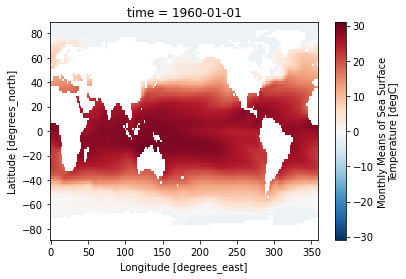

In [44]:
# your code here
sst.mean(dim=("lat","lon"))
sst[0].plot()

## Broadcasting

Broadcasting refers to the alignmed of arrays with different numbers of
dimensions. Numpy's broadcasting rules, based on array shape, can sometimes be
difficult to understand and remember. Xarray does brodcasting by dimension name,
rather than array shape. This is a huge convenience.

Let's now create two arrays with some dimensions in common. For this example, we
will create a "weights" array proportional to cosine of latitude. Modulo a
normalization, this is the correct area-weighting factor for data on a regular
lat-lon grid.


In [45]:
weights = np.cos(np.deg2rad(ds.lat))
weights.dims

('lat',)

If we multiply this by SST, it "just works," and the arrays are broadcasted
properly:


In [46]:
(ds.sst * weights).dims

('time', 'lat', 'lon')

<div class="alert alert-warning">
    <strong>Warning:</strong> If the arrays being broadcasted share a dimension name, but have different coordinates,
    they will first be aligned using Xarray's default align settings (including filling missing values with NaNs).
    If that's not what you want, it's best to call <code>align</code> explicitly before broadcasting.
</div>


## Weighted Reductions

We could imagine computing the weighted spatial mean of SST manually, like this:


Text(0.5, 1.0, 'This is wrong!')

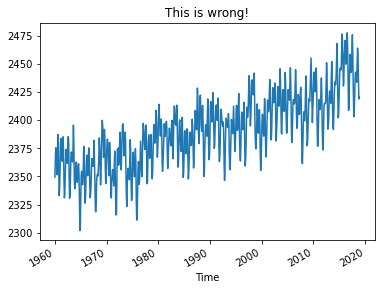

In [47]:
sst_mean = (ds.sst * weights).sum(dim=("lon", "lat")) / weights.sum(dim="lat")
sst_mean.plot()
plt.title("This is wrong!")

That would be wrong, however, because the denominator (`weights.sum(dim='lat')`)
needs to be expanded to include the `lon` dimension and modified to account for
the missing values (land points).

In general, weighted reductions on multidimensional arrays are complicated. To
make it a bit easier, Xarray provides a mechanism for weighted reductions. It
does this by creating a special intermediate `DataArrayWeighted` object, to
which different reduction operations can applied.


In [48]:
sst_weighted = ds.sst.weighted(weights)
sst_weighted

DataArrayWeighted with weights along dimensions: lat

Text(0.5, 1.0, 'Correct Global Mean SST')

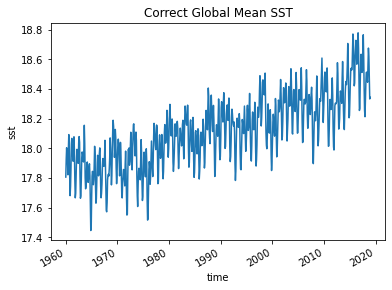

In [49]:
sst_weighted.mean(dim=("lon", "lat")).plot()
plt.title("Correct Global Mean SST")

## Groupby

Xarray copies Pandas' very useful groupby functionality, enabling the "split /
apply / combine" workflow on xarray DataArrays and Datasets.

To provide a physically motivated example, let's examine a timeseries of SST at
a single point.


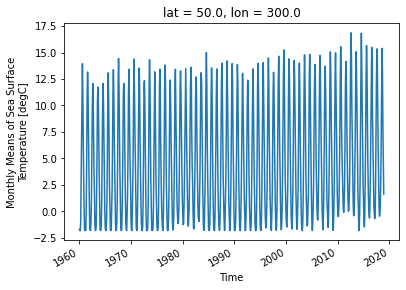

In [50]:
ds.sst.sel(lon=300, lat=50).plot()

As we can see from the plot, the timeseries at any one point is totally
dominated by the seasonal cycle. We would like to remove this seasonal cycle
(called the "climatology") in order to better see the long-term variaitions in
temperature. We can accomplish this using **groupby**.

Before moving forward, w note that xarray correctly parsed the time index,
resulting in a Pandas datetime index on the time dimension.


In [51]:
ds.time

<xarray.DataArray 'time' (time: 708)>
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    _ChunkSizes:      1
    actual_range:     [19723.0, 80505.0]
    avg_period:       0000-01-00 00:00:00
    axis:             T
    delta_t:          0000-01-00 00:00:00
    long_name:        Time
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time

The syntax of Xarray's groupby is almost identical to Pandas.


In [52]:
ds.groupby?

Signature: ds.groupby(group, squeeze: bool = True, restore_coord_dims: bool = None)
Docstring:
Returns a GroupBy object for performing grouped operations.

Parameters
----------
group : str, DataArray or IndexVariable
    Array whose unique values should be used to group this array. If a
    string, must be the name of a variable contained in this dataset.
squeeze : bool, optional
    If "group" is a dimension of any arrays in this dataset, `squeeze`
    controls whether the subarrays have a dimension of length 1 along
    that dimension or if the dimension is squeezed out.
restore_coord_dims : bool, optional
    If True, also restore the dimension order of multi-dimensional
    coordinates.

Returns
-------
grouped
    A `GroupBy` object patterned after `pandas.GroupBy` that can be
    iterated over in the form of `(unique_value, grouped_array)` pairs.

Examples
--------
Calculate daily anomalies for daily data:

>>> da = xr.DataArray(
...     np.linspace(0, 1826, num=1827),
...     c

### Split Step

The most important argument is `group`: this defines the unique values we will
us to "split" the data for grouped analysis. We can pass either a DataArray or a
name of a variable in the dataset. Lets first use a DataArray. Just like with
Pandas, we can use the time index to extract specific components of dates and
times. Xarray uses a special syntax for this `.dt`, called the
`DatetimeAccessor`.


In [53]:
ds.time.dt

In [54]:
ds.time.dt.month

<xarray.DataArray 'month' (time: 708)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
...
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01

ds.time.dt.year


We can use these arrays in a groupby operation:


In [55]:
gb = ds.groupby(ds.time.dt.month)
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Xarray also offers a more concise syntax when the variable you're grouping on is
already present in the dataset. This is identical to the previous line:


In [56]:
gb = ds.groupby("time.month")
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Now that the data are split, we can manually iterate over the group. The
iterator returns the key (group name) and the value (the actual dataset
corresponding to that group) for each group.


In [57]:
for group_name, group_ds in gb:
    # stop iterating after the first loop
    break
print(group_name)
group_ds

1


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 59)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1961-01-01 ... 2018-01-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    Conventions:                     CF-1.6, ACDD-1.3
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    cdm_data_type:                   Grid
    citation:                        Huang et al, 2017: Extended Reconstructe...
    climatology:                     Climatology is based on 1971-2000 SST, X...
    ...                              ...
    project:                         NOAA Extended Reconstructed Sea Surface ...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    source_comment:                  SSTs were observed by conventional therm...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    summary:                         ERSST.v5 is developed based on v4 after ...
    title:                           NOAA ERSSTv5 (in situ only)

### Apply & Combine

Now that we have groups defined, it's time to "apply" a calculation to the
group. Like in Pandas, these calculations can either be:

- _aggregation_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, xarray will automatically combine the aggregated
/ transformed groups back into a single object.

The most fundamental way to apply is with the `.map` method.


In [58]:
gb.map?

Signature: gb.map(func, args=(), shortcut=None, **kwargs)
Docstring:
Apply a function to each Dataset in the group and concatenate them
together into a new Dataset.

`func` is called like `func(ds, *args, **kwargs)` for each dataset `ds`
in this group.

Apply uses heuristics (like `pandas.GroupBy.apply`) to figure out how
to stack together the datasets. The rule is:

1. If the dimension along which the group coordinate is defined is
   still in the first grouped item after applying `func`, then stack
   over this dimension.
2. Otherwise, stack over the new dimension given by name of this
   grouping (the argument to the `groupby` function).

Parameters
----------
func : callable
    Callable to apply to each sub-dataset.
args : tuple, optional
    Positional arguments to pass to `func`.
**kwargs
    Used to call `func(ds, **kwargs)` for each sub-dataset `ar`.

Returns
-------
applied : Dataset or DataArray
    The result of splitting, applying and combining this dataset.
File:      ~/a

#### Aggregations

`.apply` accepts as its argument a function. We can pass an existing function:


In [59]:
gb.map(np.mean)

ValueError: passing 'axis' to Dataset reduce methods is ambiguous. Please use 'dim' instead.

Because we specified no extra arguments (like `axis`) the function was applied
over all space and time dimensions. This is not what we wanted. Instead, we
could define a custom function. This function takes a single argument--the group
dataset--and returns a new dataset to be combined:


In [ ]:
def time_mean(a):
    return a.mean(dim="time")


gb.map(time_mean)

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

Like Pandas, xarray's groupby object has many built-in aggregation operations
(e.g. `mean`, `min`, `max`, `std`, etc):


In [ ]:
# this does the same thing as the previous cell
ds_mm = gb.mean(dim="time")
ds_mm


So we did what we wanted to do: calculate the climatology at every point in the
dataset. Let's look at the data a bit.

_Climatlogy at a specific point in the North Atlantic_


In [ ]:
ds_mm.sst.sel(lon=300, lat=50).plot()

_Zonal Mean Climatolgoy_


In [ ]:
ds_mm.sst.mean(dim="lon").plot.contourf(x="month", levels=12, vmin=-2, vmax=30)

_Difference between January and July Climatology_


In [ ]:
(ds_mm.sst.sel(month=1) - ds_mm.sst.sel(month=7)).plot(vmax=10)

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the
residual, called the _anomaly_, which is the interesting part from a climate
perspective. Removing the seasonal climatology is a perfect example of a
transformation: it operates over a group, but doesn't change the size of the
dataset. Here is one way to code it


In [ ]:
def remove_time_mean(x):
    return x - x.mean(dim="time")


ds_anom = ds.groupby("time.month").map(remove_time_mean)
ds_anom

Xarray makes these sorts of transformations easy by supporting _groupby
arithmetic_. This concept is easiest explained with an example:


In [ ]:
gb = ds.groupby("time.month")
ds_anom = gb - gb.mean(dim="time")
ds_anom

Now we can view the climate signal without the overwhelming influence of the
seasonal cycle.

_Timeseries at a single point in the North Atlantic_


In [ ]:
ds_anom.sst.sel(lon=300, lat=50).plot()

_Difference between Jan. 1 2018 and Jan. 1 1960_


In [ ]:
(ds_anom.sel(time="2018-01-01") - ds_anom.sel(time="1960-01-01")).sst.plot()

## Grouby-Related: Resample, Rolling, Coarsen

Resample in xarray is nearly identical to Pandas. It is effectively a group-by
operation, and uses the same basic syntax. It can be applied only to time-index
dimensions. Here we compute the five-year mean.


In [ ]:
resample_obj = ds_anom.resample(time="5Y")
resample_obj

In [ ]:
ds_anom_resample = resample_obj.mean(dim="time")
ds_anom_resample

In [ ]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker="o")

<div class="alert alert-info">
    <strong>Note:</strong> <code>resample</code> only works with proper datetime indexes.
</div>

Rolling is also similar to pandas, but can be applied along any dimension. It
works with logical coordinates.


In [ ]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

In [ ]:
ds_anom.sst.sel(lon=300, lat=50).plot(label="monthly anom")
ds_anom_resample.sst.sel(lon=300, lat=50).plot(
    marker="o", label="5 year resample"
)
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label="12 month rolling mean")
plt.legend()

`coarsen` does something similar to `resample`, but without being aware of time.
It operates on logical coordinates only but can work on multiple dimensions at a
time.


In [ ]:
ds_anom_coarsen_time = ds_anom.coarsen(time=12).mean()

ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label="12 month rolling mean")
ds_anom_coarsen_time.sst.sel(lon=300, lat=50).plot(
    marker="^", label="12 item coarsen"
)
plt.legend()

In [ ]:
%%expect_exception
ds_anom_coarsen_space = ds_anom.coarsen(lon=4, lat=4).mean()

In [ ]:
ds_anom_coarsen_space = (
    ds_anom.isel(lat=slice(0, -1)).coarsen(lon=4, lat=4).mean()
)
ds_anom_coarsen_space

In [ ]:
ds_anom_coarsen_space.sst.isel(time=0).plot()

## Exercise

Load the following "basin mask" dataset, and use it to take a weighted average
of SST in each ocean basin. Figure out which ocean basins are the warmest and
coldest.

**Hint:** you will first need to align this dataset with the SST dataset. Use
what you learned in the "indexing and alignment" lesson.


In [62]:
basin = xr.open_dataset(
    "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods"
)
basin

<xarray.Dataset>
Dimensions:  (X: 360, Y: 180, Z: 33)
Coordinates:
  * X        (X) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * Y        (Y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    basin    (Z, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [76]:
basin_new = basin.rename({"X":"lon","Y":"lat"})
gb = basin_new.groupby(basin_new.basin)
for group_name, group_ds in gb:
    # stop iterating after the first loop
    break
print(group_name)
group_ds
ds_interp=ds.interp_like(basin_new)
# ds_interp.sst.sel(lat=group_ds.lat)
# # basin_new
# # basin_new_interp
# ds_interp
weights = np.cos(np.deg2rad(ds_interp.lat))
ds_weighted = ds_interp.weighted(weights)
ds_mean=ds_weighted.mean(dim=("lon","lat"))
ds_weighted

1.0


DatasetWeighted with weights along dimensions: lat

In [80]:
ds_interp.sst.sel(lat=group_ds.lat,lon=group_ds.lon).mean()

<xarray.DataArray 'sst' ()>
array(19.50287709)

In [83]:
def meanbasin(a):
    meanatbasin=ds_interp.sst.sel(lat=a.lat,lon=a.lon).mean()
    return meanatbasin

basintemp=gb.map(meanbasin)

In [106]:
df = basintemp.to_dataframe()

In [121]:
df['sst']=df['sst'].fillna(0)

max_basin=df['sst'].values.tolist().index(np.max(df['sst'].values))
min_basin = df['sst'].values.tolist().index(np.min(df['sst'].values))

In [71]:
ds_interp.sel(lat=group_ds.lat,lon=group_ds.lon)

<xarray.Dataset>
Dimensions:            (time: 708, stacked_Z_lat_lon: 189302)
Coordinates:
  * time               (time) datetime64[ns] 1960-01-01 ... 2018-12-01
    lon                (stacked_Z_lat_lon) float64 0.5 1.5 2.5 ... 336.5 337.5
    lat                (stacked_Z_lat_lon) float64 -49.5 -49.5 ... 19.5 19.5
  * stacked_Z_lat_lon  (stacked_Z_lat_lon) MultiIndex
  - Z                  (stacked_Z_lat_lon) float64 0.0 0.0 0.0 ... 4e+03 4e+03
  - lat                (stacked_Z_lat_lon) float64 -49.5 -49.5 ... 19.5 19.5
  - lon                (stacked_Z_lat_lon) float64 0.5 1.5 2.5 ... 336.5 337.5
Data variables:
    sst                (time, stacked_Z_lat_lon) float64 3.188 3.24 ... 23.09
Attributes: (12/38)
    Conventions:                     CF-1.6, ACDD-1.3
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      https://www.ncdc.noaa.gov/data-access/ma...
    cdm_data_type:                   Grid
    citation:                        Huang et al, 2017: Extended Reconstructe...
    climatology:                     Climatology is based on 1971-2000 SST, X...
    ...                              ...
    project:                         NOAA Extended Reconstructed Sea Surface ...
    source:                          In situ data: ICOADS R3.0 before 2015, N...
    source_comment:                  SSTs were observed by conventional therm...
    standard_name_vocabulary:        CF Standard Name Table (v40, 25 January ...
    summary:                         ERSST.v5 is developed based on v4 after ...
    title:                           NOAA ERSSTv5 (in situ only)

In [ ]:
basin_al=basin_al.assign(sst=ds_al["sst"])
basin_al

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, Z: 33, time: 708)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    basin    (Z, lat, lon) float32 ...
    sst      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  IRIDL

In [ ]:
weights = np.cos(np.deg2rad(ds_al.lat))
def weightedmean(a):
    return a.sst.weighted(weights).mean(dim=("lat","lon"))

In [ ]:
# basin_group.map(weightedmean)
# basin_group

DatasetGroupBy, grouped over 'basin'
56 groups with labels 1.0, 2.0, 3.0, ..., 56.0, 57.0, 58.0.

In [ ]:
ds_wtmean= ds_weighted.mean(dim=("lon","lat"))

In [ ]:
ds_wtmean.plot()

In [63]:
gb = basin.groupby(basin.basin)
for group_name, group_ds in gb:
    # stop iterating after the first loop
    break
print(group_name)
group_ds

1.0


<xarray.Dataset>
Dimensions:        (stacked_Z_Y_X: 189302)
Coordinates:
  * stacked_Z_Y_X  (stacked_Z_Y_X) MultiIndex
  - Z              (stacked_Z_Y_X) float64 0.0 0.0 0.0 0.0 ... 4e+03 4e+03 4e+03
  - Y              (stacked_Z_Y_X) float64 -49.5 -49.5 -49.5 ... 19.5 19.5 19.5
  - X              (stacked_Z_Y_X) float64 0.5 1.5 2.5 3.5 ... 335.5 336.5 337.5
Data variables:
    basin          (stacked_Z_Y_X) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  IRIDL